## Import des packages

In [ ]:
#!pip install numpy pathlib pandas keras tensorflow scikit-learn pyarrow requests tqdm plotly matplotlib

  Using cached numpy-2.3.1-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached pathlib-1.0.1-py3-none-any.whl.metadata (5.1 kB)
  Using cached pandas-2.3.0-cp312-cp312-win_amd64.whl.metadata (19 kB)
  Using cached keras-3.10.0-py3-none-any.whl.metadata (6.0 kB)
  Using cached tensorflow-2.19.0-cp312-cp312-win_amd64.whl.metadata (4.1 kB)
  Using cached scikit_learn-1.7.0-cp312-cp312-win_amd64.whl.metadata (14 kB)
  Using cached pyarrow-20.0.0-cp312-cp312-win_amd64.whl.metadata (3.4 kB)
  Using cached requests-2.32.4-py3-none-any.whl.metadata (4.9 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached matplotlib-3.10.3-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached absl_py-2.3.0-py3-none-any.whl.metadata (2.4 kB)
  Using cached rich-14.0.0-py3-none-any.whl.metadata (18 kB)
  Using cached namex-0.1.0-py3-none-any.whl

In [1]:
import sys
from pathlib import Path

project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Importation des modules nécessaires
import keras
from sklearn.preprocessing import MinMaxScaler

# Gestionnaire de données
from data.DataManager import DataManager

# Modèles de Deep Learning
from dl_models.MLPs import create_mlp_model,  LRHistory
from dl_models.CNNs import create_cnn_model
from dl_models.RNNs import LSTM, GRU, TKAN, create_rnn_model

# Métriques de performance / comparaison de modèles
from utils.visualization_tools import evaluate_and_plot
from utils.papers_runners import PaperEstimatorsRunner

In [ ]:
keras.utils.set_random_seed(72)

# Nombre d'itération / taille de batch
N_MAX_EPOCH = 100
BATCH_SIZE = 32

# Liste de callbacks à utiliser dans les modèles
callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss",min_delta=0.00001,patience = 10,mode = "min",restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau( monitor = "val_loss",factor = 0.25,patience = 5,min_delta = 0.00001,verbose = 0),
    LRHistory()]


# Import des données

In [ ]:
# Définition des périodes de récupération
train_period: list = [(2023,7), (2023,8), (2023, 9), (2023,10)]
test_period: list = [(2023,11)]

# Choix lié à l'utilisation des indicateurs de dépendance sérielle.
use_serial_dependance: bool = False

# Définition des actifs à récupérer
cryptos_train: list = ["ETHUSDT", "BNBUSDT", "XRPUSDT", "SOLUSDT", "ADAUSDT", "DOTUSDT"]
cryptos_test: list = ["MATICUSDT", "TRXUSDT"]

# Récupération du nombre d'actifs
nb_asset_train: int = len(cryptos_train)
nb_asset_test: int = len(cryptos_test)

# Création du datamanager pour gérer les données d'entrainement + import
manager_train: DataManager = DataManager(symbols=cryptos_train, dates=train_period, light=True)
manager_train.download_and_prepare_data()

# Construction des features / labels pour les données d'entrainement
feature_paths = manager_train.load_features(use_serial_dependance)
labels_paths = manager_train.build_labels()

# Création du datamanager pour gérer les données de test (et import)
manager_test: DataManager = DataManager(symbols=cryptos_test, dates=test_period, light=True)
manager_test.download_and_prepare_data()

# Construction des features et labels pour les données de test
feature_paths_test = manager_test.load_features(use_serial_dependance)
labels_paths_test = manager_test.build_labels()


# Test dataframe de construction de test et val
X_train, X_val, y_train, y_val = manager_train.build_train_val_dataset()

# Construction des tests
X_test, y_test = manager_test.build_train_val_dataset(is_test=True)

# Standardisation des features
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train).reshape(X_train.shape)
X_val_scaled = scaler_X.transform(X_val).reshape(X_val.shape)
X_test_scaled = scaler_X.transform(X_test).reshape(X_test.shape)

# Standardisation des labels (pour pas avoir des valeurs trop proches de 0)
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).reshape(y_train.shape)
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).reshape(y_val.shape)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).reshape(y_test.shape)

# Récupération des estimateurs papiers sur l'ensemble de test
runner = PaperEstimatorsRunner(
    symbols = cryptos_test,          
    periods = [(2023, 11)] * len(cryptos_test), 
    light_download = True
)

df_est = runner.get_estimates()
df_lab = runner._load_labels_all()
df_all = df_est.join(df_lab["spread_real"])
y_true = df_all["spread_real"].values
paper_daily = df_all.drop(columns="spread_real")

# Métriques (toutes)
df_perf = runner.evaluate()


Klines déjà existant : c:\Users\theod\OneDrive\Documents\GitHub\Deep-Learning-for-Spread-Forecasting\data\raw data\ETHUSDT-1m-2023-07.parquet
BookTicker déjà existant : c:\Users\theod\OneDrive\Documents\GitHub\Deep-Learning-for-Spread-Forecasting\data\raw data\ETHUSDT-bookTicker-2023-07.parquet
Klines déjà existant : c:\Users\theod\OneDrive\Documents\GitHub\Deep-Learning-for-Spread-Forecasting\data\raw data\ETHUSDT-1m-2023-08.parquet
BookTicker déjà existant : c:\Users\theod\OneDrive\Documents\GitHub\Deep-Learning-for-Spread-Forecasting\data\raw data\ETHUSDT-bookTicker-2023-08.parquet
Klines déjà existant : c:\Users\theod\OneDrive\Documents\GitHub\Deep-Learning-for-Spread-Forecasting\data\raw data\ETHUSDT-1m-2023-09.parquet
BookTicker déjà existant : c:\Users\theod\OneDrive\Documents\GitHub\Deep-Learning-for-Spread-Forecasting\data\raw data\ETHUSDT-bookTicker-2023-09.parquet
Klines déjà existant : c:\Users\theod\OneDrive\Documents\GitHub\Deep-Learning-for-Spread-Forecasting\data\raw da

## CNN

TRAIN CNN : (576, 1440, 15) (576, 1)
TRAIN CNN : (144, 1440, 15) (144, 1)
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 117.0089 - val_loss: 0.2512 - learning_rate: 0.0010
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.5447 - val_loss: 0.2227 - learning_rate: 0.0010
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2919 - val_loss: 0.2047 - learning_rate: 0.0010
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1180 - val_loss: 0.2052 - learning_rate: 0.0010
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0914 - val_loss: 0.2150 - learning_rate: 0.0010
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1041 - val_loss: 0.2124 - learning_rate: 0.0010
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0928 - val_loss: 0.2109 - learning_rate: 0.0010
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1003 - val_loss: 0.2132 - learning_rate: 0.0010
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24

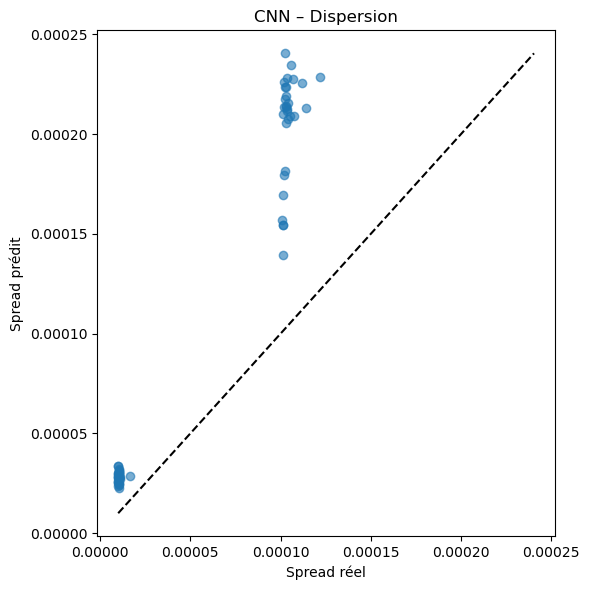

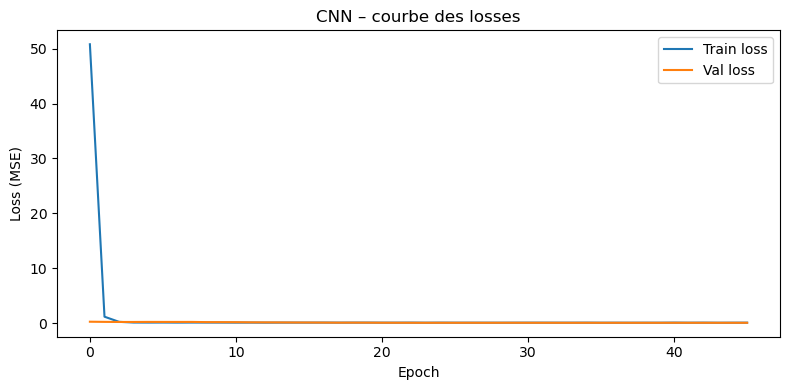

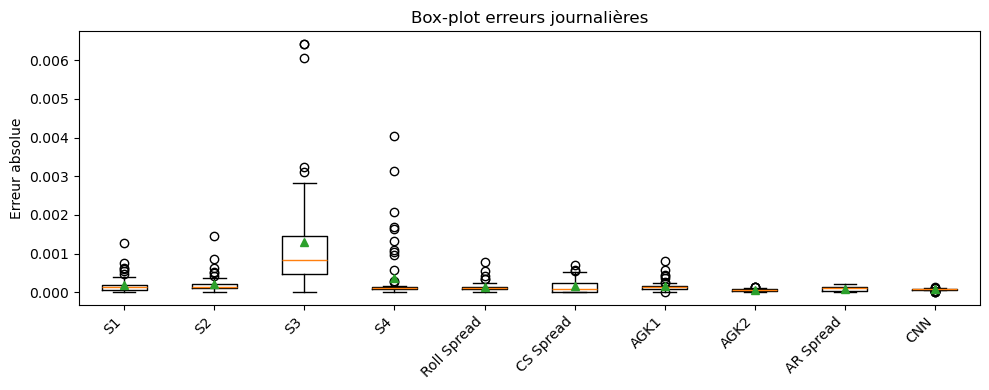

,R²,RMSE,MAE
S1,-222.608059,0.000284,0.000187
S2,-245.777907,0.000298,0.000199
S3,-9972.306909,0.001895,0.001291
S4,-1935.049776,0.000835,0.000375
Roll Spread,-93.595646,0.000185,0.000136
CS Spread,-147.796496,0.000231,0.000154
AGK1,-109.575991,0.000200,0.000150
AGK2,-10.938703,0.000066,0.000058
AR Spread,-27.382045,0.000101,0.000089
CNN,NaN,0.000075,0.000060


,R²,RMSE,MAE
S1,-222.608059,0.000284,0.000187
S2,-245.777907,0.000298,0.000199
S3,-9972.306909,0.001895,0.001291
S4,-1935.049776,0.000835,0.000375
Roll Spread,-93.595646,0.000185,0.000136
CS Spread,-147.796496,0.000231,0.000154
AGK1,-109.575991,0.000200,0.000150
AGK2,-10.938703,0.000066,0.000058
AR Spread,-27.382045,0.000101,0.000089
CNN,NaN,0.000075,0.000060


In [6]:
# Train CNN
X_tr_cnn, y_tr_cnn = manager_train.format_data(X_train_scaled, y_train_scaled,model_type='cnn',nb_assets=nb_asset_train,minutes_per_day=1440)
print("TRAIN CNN :", X_tr_cnn.shape, y_tr_cnn.shape)

#  Val CNN
X_val_cnn, y_val_cnn = manager_train.format_data(X_val_scaled, y_val_scaled,model_type='cnn',nb_assets=nb_asset_train,minutes_per_day=1440)
print("TRAIN CNN :", X_val_cnn.shape, y_val_cnn.shape)

# Création et entraînement du CNN
input_shape = X_tr_cnn.shape[1:]     # (1440, 16)
cnn = create_cnn_model(input_shape=input_shape, model_type="simple",output_activation='linear')

history = cnn.fit(X_tr_cnn, y_tr_cnn,validation_data=(X_val_cnn, y_val_cnn),epochs=N_MAX_EPOCH,batch_size=BATCH_SIZE,verbose=1,callbacks=callbacks)

# Formatage des features de test
X_te_cnn, y_te_cnn = manager_test.format_data(X_test_scaled,y_test_scaled,model_type='cnn',nb_assets=nb_asset_test,minutes_per_day=1440)
print("TEST CNN :", X_te_cnn.shape, y_te_cnn.shape)

# Résultat pour le CNN
evaluate_and_plot(model = cnn,X = X_te_cnn,y = y_te_cnn,manager = manager_test,scaler_y=scaler_y,title = "CNN",
                  history = history,paper_daily = paper_daily,paper_metrics = df_perf,y_true_daily = y_true)  
    


## MLP

TRAIN MLP : (576, 21600) (576, 1)
VAL MLP : (144, 21600) (144, 1)
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 3.2580 - val_loss: 0.1110 - learning_rate: 0.0010
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1065 - val_loss: 0.0850 - learning_rate: 0.0010
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0697 - val_loss: 0.0691 - learning_rate: 0.0010
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0548 - val_loss: 0.0478 - learning_rate: 0.0010
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0489 - val_loss: 0.0407 - learning_rate: 0.0010
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0483 - val_loss: 0.0414 - learning_rate: 0.0010
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0520 - val_loss: 0.0432 - learning_rate: 0.0010
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0523 - val_loss: 0.0460 - learning_rate: 0.0010
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - 

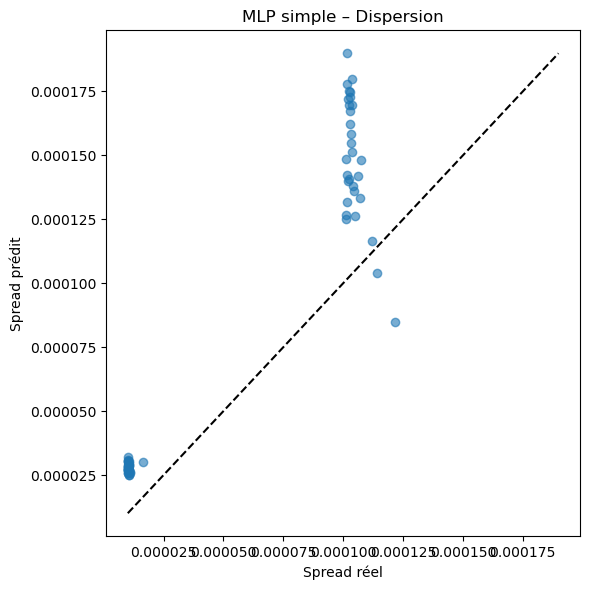

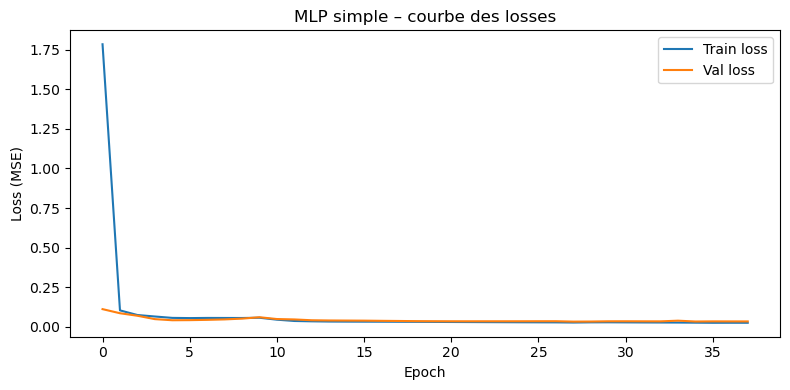

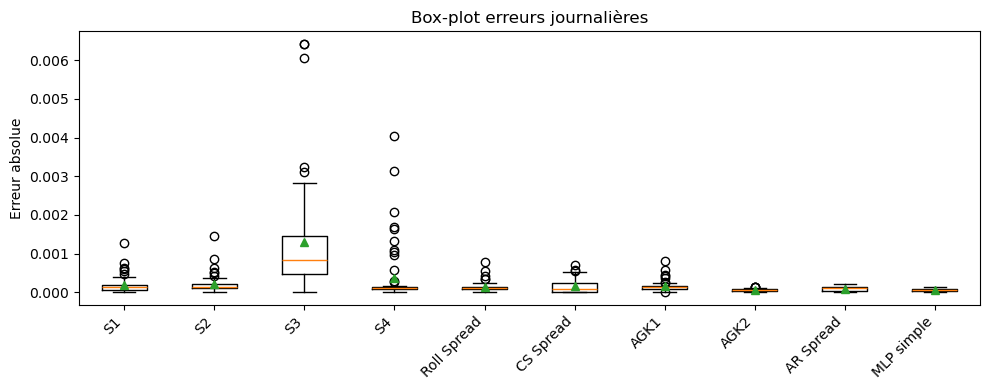

,R²,RMSE,MAE
S1,-222.608059,0.000284,0.000187
S2,-245.777907,0.000298,0.000199
S3,-9972.306909,0.001895,0.001291
S4,-1935.049776,0.000835,0.000375
Roll Spread,-93.595646,0.000185,0.000136
CS Spread,-147.796496,0.000231,0.000154
AGK1,-109.575991,0.000200,0.000150
AGK2,-10.938703,0.000066,0.000058
AR Spread,-27.382045,0.000101,0.000089
MLP simple,NaN,0.000039,0.000032


,R²,RMSE,MAE
S1,-222.608059,0.000284,0.000187
S2,-245.777907,0.000298,0.000199
S3,-9972.306909,0.001895,0.001291
S4,-1935.049776,0.000835,0.000375
Roll Spread,-93.595646,0.000185,0.000136
CS Spread,-147.796496,0.000231,0.000154
AGK1,-109.575991,0.000200,0.000150
AGK2,-10.938703,0.000066,0.000058
AR Spread,-27.382045,0.000101,0.000089
MLP simple,NaN,0.000039,0.000032


In [ ]:
# Mise en forme des données pour le MLP
X_tr_mlp, y_tr_mlp = manager_train.format_data(X_train_scaled, y_train_scaled,model_type='mlp',nb_assets=nb_asset_train,minutes_per_day=1440)    
print("TRAIN MLP :", X_tr_mlp.shape, y_tr_mlp.shape)

#  Val CNN
X_val_mlp, y_val_mlp = manager_train.format_data(X_val_scaled, y_val_scaled,model_type='mlp',nb_assets=nb_asset_train,minutes_per_day=1440)
print("VAL MLP :", X_val_mlp.shape, y_val_mlp.shape)


# Construction et entraînement du modèle MLP
input_shape = X_tr_mlp.shape
mlp = create_mlp_model(input_shape=input_shape,model_type="simple",hidden_dims=[128, 64, 32],output_activation  = "linear")
    

history_mlp = mlp.fit(X_tr_mlp, y_tr_mlp,validation_data = (X_val_mlp, y_val_mlp),epochs=N_MAX_EPOCH,batch_size=BATCH_SIZE,verbose=1,callbacks=callbacks)

#Préparation du set de test au même format
X_te_mlp, y_te_mlp = manager_test.format_data(X_test_scaled, y_test_scaled,model_type='mlp',nb_assets=nb_asset_test,minutes_per_day=1440)
print("TEST  MLP :", X_te_mlp.shape, y_te_mlp.shape)

# Graphique et comparaison avec les estimateurs de Garcin
evaluate_and_plot(model = mlp,X = X_te_mlp,y = y_te_mlp,manager = manager_test,title = "MLP simple",
                  scaler_y= scaler_y,history = history_mlp,paper_daily = paper_daily,paper_metrics = df_perf,y_true_daily = y_true,)      
    


## RNN LSTM

TRAIN RNN : (576, 1440, 15) (576, 1)
VAL   RNN : (144, 1440, 15) (144, 1)
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 329ms/step - loss: 0.1477 - mae: 0.3229 - val_loss: 0.0701 - val_mae: 0.2197 - learning_rate: 0.0010
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 315ms/step - loss: 0.0653 - mae: 0.2054 - val_loss: 0.0528 - val_mae: 0.1554 - learning_rate: 0.0010
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 322ms/step - loss: 0.0580 - mae: 0.1795 - val_loss: 0.0491 - val_mae: 0.1509 - learning_rate: 0.0010
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 292ms/step - loss: 0.0550 - mae: 0.1707 - val_loss: 0.0545 - val_mae: 0.1620 - learning_rate: 0.0010
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 295ms/step - loss: 0.0560 - mae: 0.1699 - val_loss: 0.0573 - val_mae: 0.1679 - learning_rate: 0.0010
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 291ms/step - loss: 0.0525 - mae: 0.1644 - val_loss: 0.0500 - val_mae: 0.1561 - learning_rate: 0.0010
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 284ms/step - loss: 0.0601 

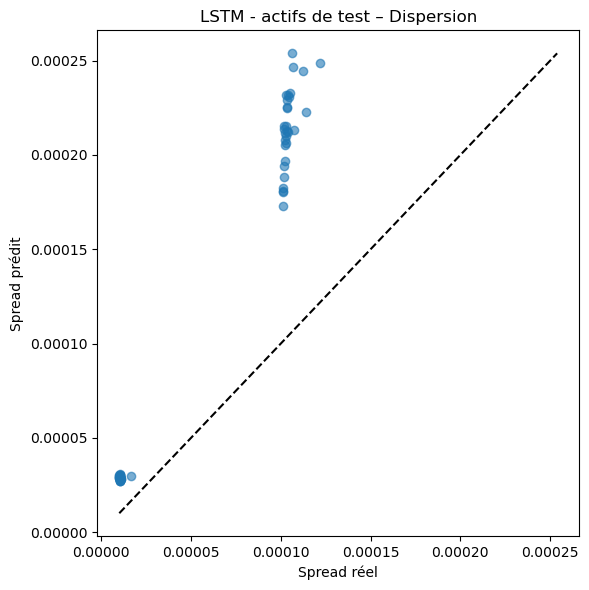

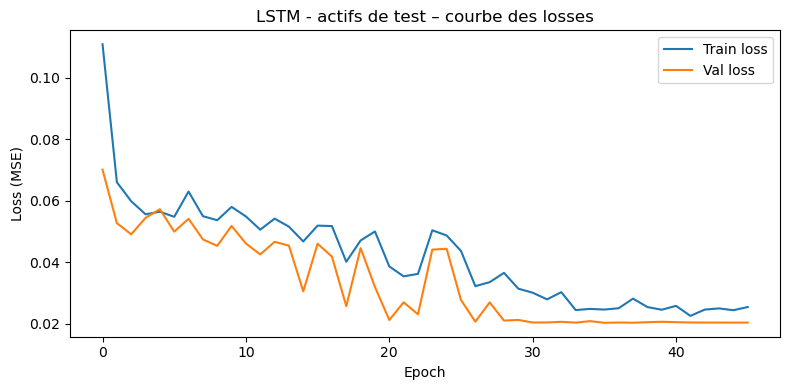

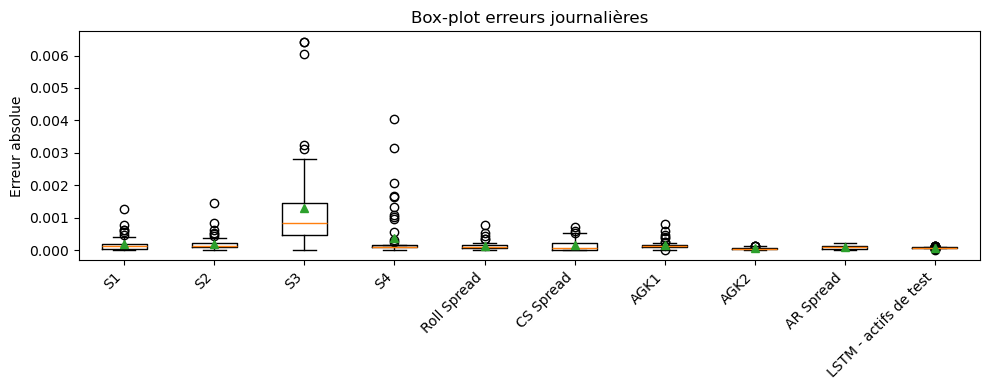

,R²,RMSE,MAE
S1,-222.608059,0.000284,0.000187
S2,-245.777907,0.000298,0.000199
S3,-9972.306909,0.001895,0.001291
S4,-1935.049776,0.000835,0.000375
Roll Spread,-93.595646,0.000185,0.000136
CS Spread,-147.796496,0.000231,0.000154
AGK1,-109.575991,0.000200,0.000150
AGK2,-10.938703,0.000066,0.000058
AR Spread,-27.382045,0.000101,0.000089
LSTM - actifs de test,NaN,0.000080,0.000064


In [ ]:
# Mise en forme TRAIN / VAL  
X_tr_rnn, y_tr_rnn = manager_train.format_data(X_train_scaled, y_train_scaled,model_type = 'rnn',nb_assets = nb_asset_train,minutes_per_day = 1440)
print("TRAIN RNN :", X_tr_rnn.shape, y_tr_rnn.shape)

X_val_rnn, y_val_rnn = manager_train.format_data(X_val_scaled, y_val_scaled,model_type = 'rnn',nb_assets = nb_asset_train,minutes_per_day = 1440)
print("VAL   RNN :", X_val_rnn.shape, y_val_rnn.shape)

from dl_models.RNNs import create_native_lstm_model

input_shape = X_tr_rnn.shape[1:] 
rnn = create_native_lstm_model(input_shape, nb_assets=1)


# Entraînement
history_rnn = rnn.fit(X_tr_rnn, y_tr_rnn,validation_data = (X_val_rnn, y_val_rnn),epochs = N_MAX_EPOCH,batch_size = BATCH_SIZE,verbose = 1,callbacks = callbacks)
    
# Préparation du TEST
X_te_rnn, y_te_rnn = manager_test.format_data(X_test_scaled, y_test_scaled,model_type = 'rnn',nb_assets = nb_asset_test,minutes_per_day = 1440)
    
# Évaluation & visualisation
df_compare_rnn = evaluate_and_plot(model = rnn,X = X_te_rnn,y = y_te_rnn,manager = manager_test,scaler_y = scaler_y,title = "LSTM - actifs de test",
                                   history = history_rnn,paper_metrics = df_perf,paper_daily = paper_daily,y_true_daily  = y_true)




## RNN GRU

In [ ]:
X_tr_gru, y_tr_gru = manager_train.format_data(X_train_scaled, y_train_scaled,model_type='rnn',nb_assets=nb_asset_train,minutes_per_day=1440) 
print("TRAIN GRU :", X_tr_gru.shape, y_tr_gru.shape)

X_val_gru, y_val_gru = manager_train.format_data(X_val_scaled, y_val_scaled,model_type = 'rnn',nb_assets = nb_asset_train,minutes_per_day = 1440)
print("VAL GRU :", X_val_gru.shape, y_val_gru.shape)


input_shape = X_tr_gru.shape[1:]  
gru_model = create_rnn_model(input_shape = input_shape,nb_assets = 1,rnn_layer = GRU(units=100, return_sequences=False, dropout=0.3),use_conv = False)
    
history_gru = gru_model.fit(X_tr_gru, y_tr_gru,validation_data = (X_val_gru, y_val_gru),epochs = N_MAX_EPOCH,batch_size = BATCH_SIZE,verbose = 1,callbacks = callbacks)  
    
X_te_gru, y_te_gru = manager_test.format_data(X_test_scaled, y_test_scaled,model_type='rnn',nb_assets=1,minutes_per_day=1440)
print("TEST GRU :", X_te_gru.shape, y_te_gru.shape)

df_compare_gru = evaluate_and_plot(model = gru_model,X = X_te_gru,y = y_te_gru,manager = manager_test,scaler_y = scaler_y,
                                   title = "GRU - actifs de test",history = history_gru,paper_metrics = df_perf,paper_daily = paper_daily,y_true_daily = y_true)    
    


TRAIN GRU : (576, 1440, 15) (576, 1)
VAL GRU : (144, 1440, 15) (144, 1)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 834s 18s/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan - learning_rate: 0.0010
Epoch 2/100
 4/18 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - loss: nan - mae: nan

KeyboardInterrupt: 

## RNN TKAN

TRAIN TKAN : (571, 5, 21600) (571, 1)
VAL   TKAN : (139, 5, 21600) (139, 1)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 0.3631 - mae: 0.3593 - val_loss: 0.0425 - val_mae: 0.1373 - learning_rate: 0.0010
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0416 - mae: 0.1375 - val_loss: 0.0255 - val_mae: 0.1143 - learning_rate: 0.0010
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0323 - mae: 0.1315 - val_loss: 0.0247 - val_mae: 0.1183 - learning_rate: 0.0010
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0292 - mae: 0.1259 - val_loss: 0.0238 - val_mae: 0.1125 - learning_rate: 0.0010
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0279 - mae: 0.1228 - val_loss: 0.0237 - val_mae: 0.1101 - learning_rate: 0.0010
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0285 - mae: 0.1259 - val_loss: 0.0237 - val_mae: 0.1104 - learning_rate: 0.0010
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0271 - ma

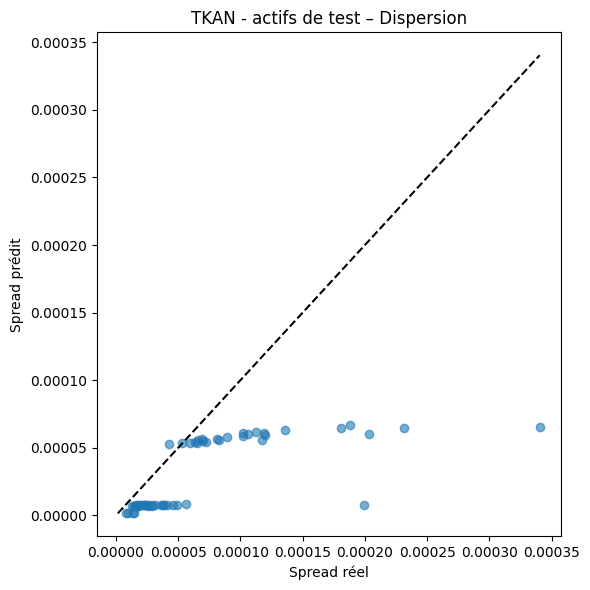

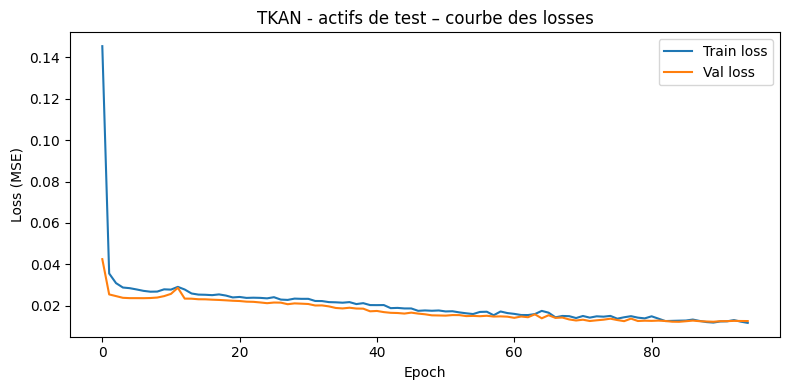

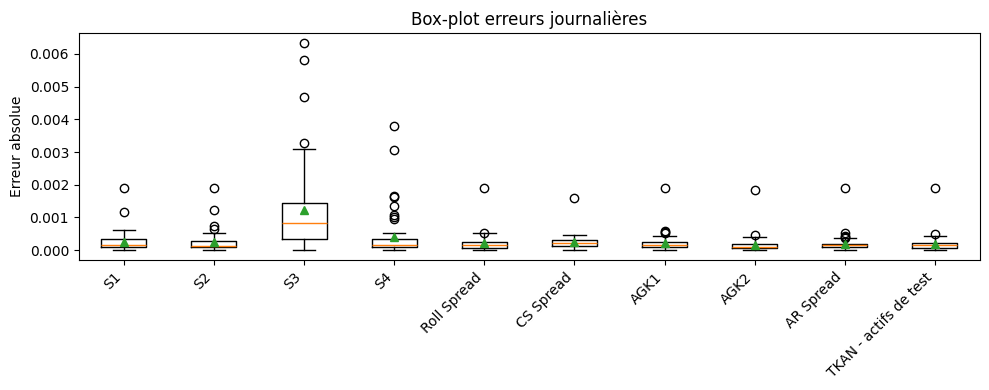

,R²,RMSE,MAE
S1,-1.412604,0.000383,0.000250
S2,-1.352921,0.000378,0.000232
S3,-50.774463,0.001773,0.001210
S4,-8.976766,0.000778,0.000390
Roll Spread,-0.716192,0.000323,0.000196
CS Spread,-0.734822,0.000325,0.000240
AGK1,-0.767330,0.000328,0.000202
AGK2,-0.397044,0.000291,0.000156
AR Spread,-0.542225,0.000306,0.000178
TKAN - actifs de test,NaN,0.000065,0.000039


In [ ]:

WINDOW = 5          # nombre de jours d’historique vus par la séquence

X_tr_tkan, y_tr_tkan = manager_train.format_data(X_train_scaled, y_train_scaled,model_type='seq',nb_assets=nb_asset_train,minutes_per_day=1440,window=WINDOW)
print("TRAIN TKAN :", X_tr_tkan.shape, y_tr_tkan.shape)

X_val_tkan, y_val_tkan = manager_train.format_data(X_val_scaled, y_val_scaled,model_type='seq',nb_assets=nb_asset_train,minutes_per_day=1440,window=WINDOW)  
print("VAL   TKAN :", X_val_tkan.shape, y_val_tkan.shape)


input_shape = X_tr_tkan.shape[1:]   
tkan_model  = create_rnn_model(input_shape = input_shape,nb_assets = 1,rnn_layer = TKAN(units=100, num_heads=4, return_sequences=False),use_conv = False)   


history_tkan = tkan_model.fit(X_tr_tkan, y_tr_tkan,validation_data = (X_val_tkan, y_val_tkan),epochs = N_MAX_EPOCH,batch_size = BATCH_SIZE,verbose = 1,callbacks = callbacks)
    

X_te_tkan, y_te_tkan = manager_test.format_data(X_test_scaled, y_test_scaled,model_type='seq',nb_assets=nb_asset_test,minutes_per_day=1440,window=WINDOW)
print("TEST TKAN :", X_te_tkan.shape, y_te_tkan.shape)

y_true_aligned  = y_true[WINDOW:]            
paper_daily_aligned  = paper_daily.iloc[WINDOW:]

df_compare_tkan = evaluate_and_plot(model = tkan_model,X = X_te_tkan,y = y_te_tkan,manager = manager_test,scaler_y = scaler_y,title = "TKAN - actifs de test",
                                    history = history_tkan,paper_metrics = df_perf,paper_daily = paper_daily_aligned,y_true_daily   = y_true_aligned)      
    


TRAIN TKAN : (571, 5, 21600) (571, 1)
VAL   TKAN : (139, 5, 21600) (139, 1)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.4364 - mae: 0.4948 - val_loss: 0.1984 - val_mae: 0.3295 - learning_rate: 0.0010
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.2330 - mae: 0.3610 - val_loss: 0.1953 - val_mae: 0.3238 - learning_rate: 0.0010
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.2083 - mae: 0.3362 - val_loss: 0.1005 - val_mae: 0.2519 - learning_rate: 0.0010
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.1178 - mae: 0.2796 - val_loss: 0.0875 - val_mae: 0.2468 - learning_rate: 0.0010
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.1109 - mae: 0.2699 - val_loss: 0.0751 - val_mae: 0.2341 - learning_rate: 0.0010
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0967 - mae: 0.2567 - val_loss: 0.0710 - val_mae: 0.2256 - learning_rate: 0.0010
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0955 - ma

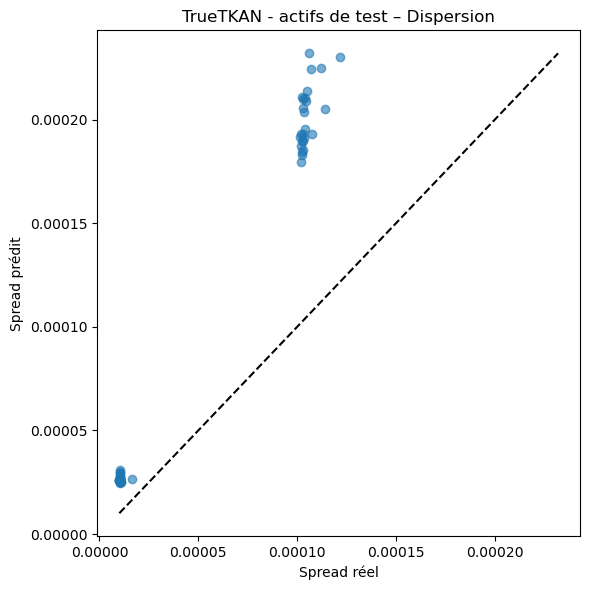

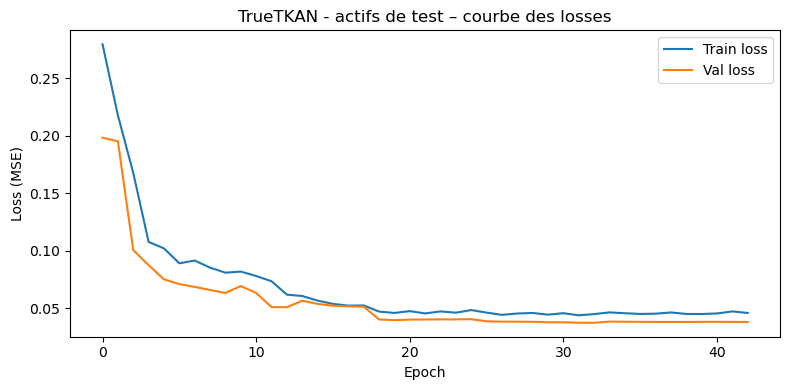

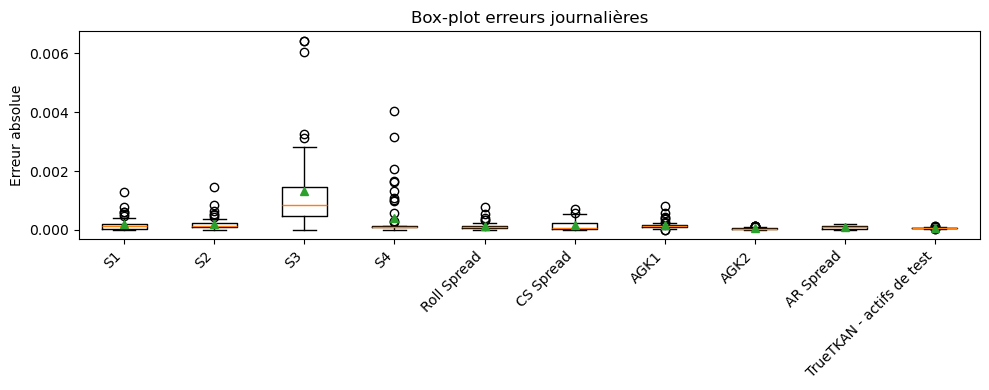

,R²,RMSE,MAE
S1,-222.608059,0.000284,0.000187
S2,-245.777907,0.000298,0.000199
S3,-9972.306909,0.001895,0.001291
S4,-1935.049776,0.000835,0.000375
Roll Spread,-93.595646,0.000185,0.000136
CS Spread,-147.796496,0.000231,0.000154
AGK1,-109.575991,0.000200,0.000150
AGK2,-10.938703,0.000066,0.000058
AR Spread,-27.382045,0.000101,0.000089
TrueTKAN - actifs de test,NaN,0.000067,0.000053


In [ ]:

# nombre de jours d’historique visibles par séquence
WINDOW = 5   


# Préparation des séquences TRAIN / VAL
X_tr_tkan, y_tr_tkan = manager_train.format_data(X_train_scaled, y_train_scaled,model_type = "seq",nb_assets= nb_asset_train,minutes_per_day = 1440,window = WINDOW)
print("TRAIN TKAN :", X_tr_tkan.shape, y_tr_tkan.shape)

X_val_tkan, y_val_tkan = manager_train.format_data(X_val_scaled, y_val_scaled,model_type = "seq",nb_assets = nb_asset_train,minutes_per_day = 1440,window = WINDOW)
print("VAL   TKAN :", X_val_tkan.shape, y_val_tkan.shape)

# Construction du modèle TKAN )
input_shape = X_tr_tkan.shape[1:]   

tkan_model = create_rnn_model(
    input_shape = X_tr_tkan.shape[1:],
    nb_assets   = 1,
    rnn_layer   = TKAN(units = 100,num_heads = 4,dropout= 0.1,return_sequences = False,num_branches= 32),use_conv = False)
       

# Entraînement
history_tkan = tkan_model.fit(X_tr_tkan, y_tr_tkan,validation_data = (X_val_tkan, y_val_tkan),epochs = N_MAX_EPOCH,batch_size = BATCH_SIZE,verbose = 1,callbacks = callbacks)
    
# Préparation du TEST
X_te_tkan, y_te_tkan = manager_test.format_data(X_test_scaled, y_test_scaled,model_type = "seq",nb_assets = nb_asset_test,minutes_per_day = 1440,window = WINDOW)   
print("TEST TKAN :", X_te_tkan.shape, y_te_tkan.shape)

# Décalage des métriques papier / y_true (car WINDOW=5)
y_true_aligned = y_true[WINDOW:]
paper_daily_aligned = paper_daily.iloc[WINDOW:]


# Évaluation + graphiques
df_compare_tkan = evaluate_and_plot( model = tkan_model,X = X_te_tkan,y = y_te_tkan,manager = manager_test,scaler_y = scaler_y,title = "TrueTKAN - actifs de test",
                                    history = history_tkan,paper_metrics = df_perf,paper_daily   = paper_daily_aligned,y_true_daily  = y_true_aligned
)
